# Socioeconomic Context: Chicago Hardship Index

This notebook summarizes socioeconomic hardship across Chicago community areas using the Chicago Hardship Index, and links it (contextually) to ZIP-code–grouped hospitalization results for asthma and diabetes.

Because ZIP codes and community areas do not align perfectly, ZIP codes are assigned to a *dominant* community area using a population-weighted ZIP–community area crosswalk (2010 Census overlap). This linkage is used for contextual interpretation rather than precise geographic attribution.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 1) Load and review the hardship index

In [23]:
hardship = pd.read_csv("../data/hardship_index.csv")
hardship.columns = hardship.columns.str.strip()

hardship[["COMMUNITY AREA NAME", "HARDSHIP INDEX"]].head()

,COMMUNITY AREA NAME,HARDSHIP INDEX
0,Rogers Park,39.0
1,West Ridge,46.0
2,Uptown,20.0
3,Lincoln Square,17.0
4,North Center,6.0


In [25]:
hardship["HARDSHIP INDEX"].isna().sum()

1

### Highest-hardship community areas (ranked)

This ranking provides socioeconomic context at the community-area level.

In [30]:
hardship_ranked = (
    hardship[["COMMUNITY AREA NAME", "HARDSHIP INDEX"]]
    .dropna(subset=["HARDSHIP INDEX"])
    .sort_values("HARDSHIP INDEX", ascending=False)
    .reset_index(drop=True)
)
hardship_ranked.head(10)

,COMMUNITY AREA NAME,HARDSHIP INDEX
0,Riverdale,98.0
1,Fuller Park,97.0
2,South Lawndale,96.0
3,Englewood,94.0
4,Gage Park,93.0
5,West Garfield Park,92.0
6,New City,91.0
7,West Englewood,89.0
8,Washington Park,88.0
9,North Lawndale,87.0


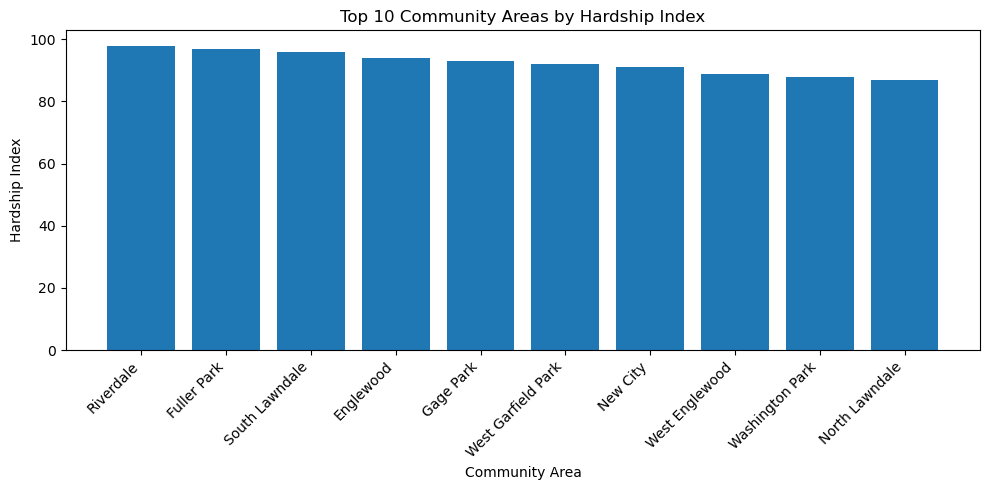

In [32]:
top_n = 10
top_hardship = hardship_ranked.head(top_n)

plt.figure(figsize=(10, 5))
plt.bar(top_hardship["COMMUNITY AREA NAME"], top_hardship["HARDSHIP INDEX"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Community Area")
plt.ylabel("Hardship Index")
plt.title(f"Top {top_n} Community Areas by Hardship Index")
plt.tight_layout()
plt.show()

## 2) Build a ZIP → dominant community area mapping

We use a population-weighted ZIP–community area crosswalk (2010 Census overlap). For each ZIP code, we select the community area with the largest `TOT2010` overlap.

In [35]:
ca_lookup = pd.read_excel("../data/community_area_lookup.xlsx")

crosswalk = pd.read_csv("../data/Community area and zip code equivalency.csv")
crosswalk.columns = crosswalk.columns.str.strip()

crosswalk.head()

,CHGOCA,ZCTA5,TOT2010
0,1,60626,48980
1,1,60645,5820
2,1,60660,191
3,2,60626,1159
4,2,60645,39454


In [36]:
zip_to_ca = (
    crosswalk
    .dropna(subset=["ZCTA5", "CHGOCA", "TOT2010"])
    .sort_values(["ZCTA5", "TOT2010"], ascending=[True, False])
    .drop_duplicates(subset=["ZCTA5"])
    .rename(columns={"ZCTA5": "zip_code"})
    [["zip_code", "CHGOCA", "TOT2010"]]
    .reset_index(drop=True)
)

zip_to_ca = zip_to_ca.merge(ca_lookup, on="CHGOCA", how="left")

# Sanity check: all ZIPs should resolve to a community area name
zip_to_ca["COMMUNITY AREA NAME"].isna().sum()

0

In [39]:
zip_to_ca_hardship = zip_to_ca.merge(
    hardship[["COMMUNITY AREA NAME", "HARDSHIP INDEX"]],
    on="COMMUNITY AREA NAME",
    how="left"
)

# Sanity check: hardship index should resolve for most rows
zip_to_ca_hardship["HARDSHIP INDEX"].isna().sum()

2

## 3) Recompute 5-year (2007–2011) average hospitalization rates by ZIP group

This mirrors the approach used in the asthma and diabetes notebooks so results are comparable.

In [49]:
asthma = pd.read_csv("../data/asthma_hospitalizations.csv")
diabetes = pd.read_csv("../data/diabetes_hospitalizations.csv")

asthma.columns = asthma.columns.str.strip()
diabetes.columns = diabetes.columns.str.strip()

years = [2007, 2008, 2009, 2010, 2011]

In [60]:
# Asthma (Adjusted Rate, Ages 5–64)
asthma_rate_cols = [f"Adjusted Rate {y} (Ages 5-64 only)" for y in years]

asthma_5yr = asthma[["ZIP code (or aggregate)"] + asthma_rate_cols].copy()
asthma_5yr["asthma_avg_rate"] = asthma_5yr[asthma_rate_cols].mean(axis=1, skipna=True)

asthma_5yr = asthma_5yr.rename(columns={"ZIP code (or aggregate)": "zip_group"})[
    ["zip_group", "asthma_avg_rate"]
]

In [62]:
# Diabetes (Adjusted Rate)
diabetes_rate_cols = [f"Adjusted Rate {y}" for y in years]

diabetes_5yr = diabetes[["ZIP code (or aggregate)"] + diabetes_rate_cols].copy()
diabetes_5yr["diabetes_avg_rate"] = diabetes_5yr[diabetes_rate_cols].mean(axis=1, skipna=True)

diabetes_5yr = diabetes_5yr.rename(columns={"ZIP code (or aggregate)": "zip_group"})[
    ["zip_group", "diabetes_avg_rate"]
]

## 4) Attach hardship context to ZIP-group results

We join ZIP-group results to the dominant community area and hardship index. This is intended for contextual interpretation.

In [65]:
comparison = pd.merge(asthma_5yr, diabetes_5yr, on="zip_group", how="inner")

# Make sure zip_group is numeric ZIP when possible (some datasets may store as int)
comparison["zip_code"] = pd.to_numeric(comparison["zip_group"], errors="coerce")

comparison_with_hardship = comparison.merge(
    zip_to_ca_hardship[["zip_code", "CHGOCA", "COMMUNITY AREA NAME", "HARDSHIP INDEX", "TOT2010"]],
    on="zip_code",
    how="left"
)

comparison_with_hardship.head()

,zip_group,asthma_avg_rate,diabetes_avg_rate,zip_code,CHGOCA,COMMUNITY AREA NAME,HARDSHIP INDEX,TOT2010
0,"60606, 60607 & 60661",14.20,19.02,NaN,NaN,NaN,NaN,NaN
1,"60601, 60602, 60603, 60604, 60605 & 60611",8.32,7.40,NaN,NaN,NaN,NaN,NaN
2,60608,15.44,28.12,60608.0,31.0,Lower West Side,76.0,34380.0
3,60609,27.96,37.02,60609.0,61.0,New City,91.0,44377.0
4,60610 & 60654,24.08,13.90,NaN,NaN,NaN,NaN,NaN


In [67]:
# Show top ZIP groups by asthma and diabetes with hardship context
TOP_N = 10

top_asthma = comparison_with_hardship.sort_values("asthma_avg_rate", ascending=False).head(TOP_N)
top_diabetes = comparison_with_hardship.sort_values("diabetes_avg_rate", ascending=False).head(TOP_N)

top_union_zip = set(top_asthma["zip_group"]).union(set(top_diabetes["zip_group"]))

focus = (
    comparison_with_hardship[comparison_with_hardship["zip_group"].isin(top_union_zip)]
    .sort_values(["asthma_avg_rate", "diabetes_avg_rate"], ascending=[False, False])
    .reset_index(drop=True)
)

focus[[
    "zip_group",
    "asthma_avg_rate",
    "diabetes_avg_rate",
    "COMMUNITY AREA NAME",
    "HARDSHIP INDEX"
]]

,zip_group,asthma_avg_rate,diabetes_avg_rate,COMMUNITY AREA NAME,HARDSHIP INDEX
0,60624,75.10,53.26,West Garfield Park,92.0
1,60636,71.92,55.66,West Englewood,89.0
2,60621,70.88,59.32,Englewood,94.0
3,60649,55.10,49.62,South Shore,55.0
4,60644,51.66,55.88,Austin,73.0
5,60651,51.16,51.72,Humboldt Park,NaN
6,60619,50.76,49.62,Chatham,60.0
7,60612,49.72,51.82,Near West Side,15.0
8,60637,46.10,40.10,Woodlawn,58.0
9,60628,44.56,50.26,Roseland,52.0


In [76]:
df = comparison_with_hardship.copy()

# Keep only complete rows for this summary
df = df.dropna(subset=[
    "HARDSHIP INDEX",
    "asthma_avg_rate",
    "diabetes_avg_rate"
]).copy()

# Create hardship quartiles
df["hardship_quartile"] = pd.qcut(
    df["HARDSHIP INDEX"],
    q=4,
    labels=["Q1 (Lowest)", "Q2", "Q3", "Q4 (Highest)"]
)

summary = (
    df.groupby("hardship_quartile", observed=True)[
        ["asthma_avg_rate", "diabetes_avg_rate"]
    ]
    .mean()
    .reset_index()
)
summary

,hardship_quartile,asthma_avg_rate,diabetes_avg_rate
0,Q1 (Lowest),13.665455,19.849091
1,Q2,13.760000,20.992727
2,Q3,37.057778,40.164444
3,Q4 (Highest),39.884000,41.540000


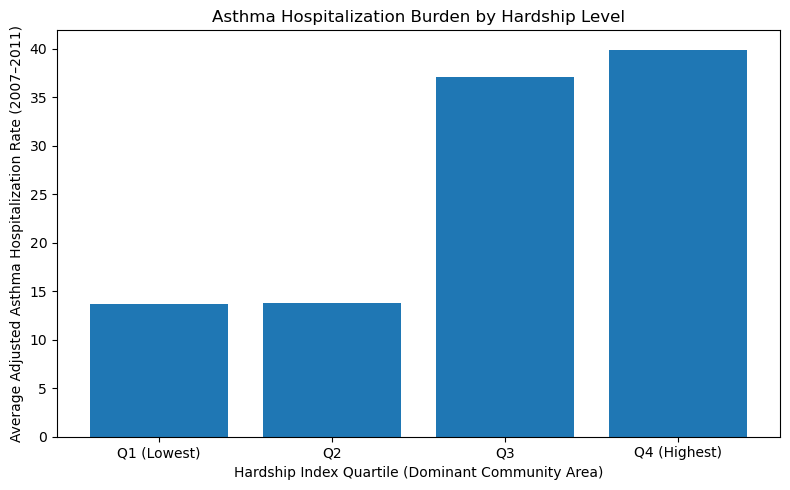

In [78]:
#Asthma vs hardship graph

plt.figure(figsize=(8, 5))
plt.bar(summary["hardship_quartile"], summary["asthma_avg_rate"])
plt.xlabel("Hardship Index Quartile (Dominant Community Area)")
plt.ylabel("Average Adjusted Asthma Hospitalization Rate (2007–2011)")
plt.title("Asthma Hospitalization Burden by Hardship Level")
plt.tight_layout()
plt.show()

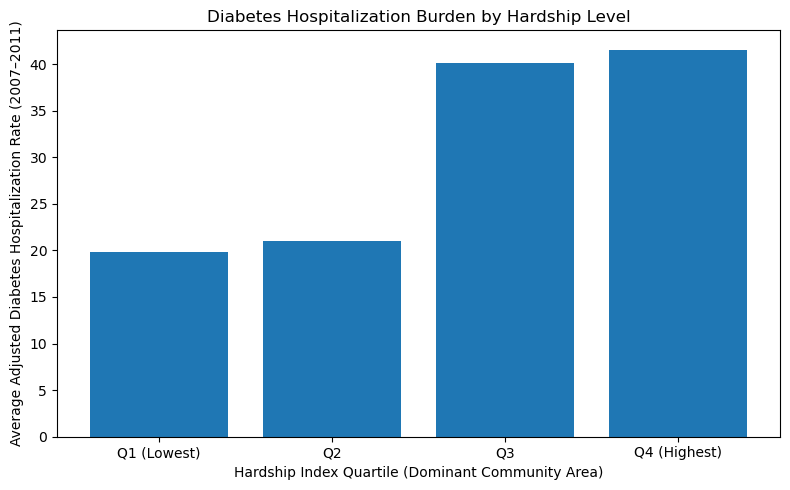

In [80]:
#Diabetes Hardship Graph
plt.figure(figsize=(8, 5))
plt.bar(summary["hardship_quartile"], summary["diabetes_avg_rate"])
plt.xlabel("Hardship Index Quartile (Dominant Community Area)")
plt.ylabel("Average Adjusted Diabetes Hospitalization Rate (2007–2011)")
plt.title("Diabetes Hospitalization Burden by Hardship Level")
plt.tight_layout()
plt.show()

## Summary and Interpretation

This analysis examined socioeconomic hardship as contextual background for geographic
patterns in asthma and diabetes hospitalization burden across Chicago. Using a
population weighted ZIP Code to community area crosswalk, ZIP code groupings were linked to a dominant community area, allowing hardship index values (reported at the community area
level) to be associated with ZIP-based hospitalization results for descriptive comparison.

When ZIP groups are grouped by hardship index quartiles, average hospitalization rates
differ across hardship levels for both asthma and diabetes. ZIP code groupings associated
with higher-hardship community areas generally exhibit higher average hospitalization
burden compared to those associated with lower-hardship areas. This pattern is consistent
with broader public health literature describing the geographic concentration of chronic
disease burden in socioeconomically disadvantaged areas.

Importantly, these results are descriptive and contextual in nature. Because ZIP code
boundaries and community areas do not align perfectly, hardship index values were linked
to ZIP groups using a dominant-area approximation rather than exact geographic matching.
As a result, the observed patterns are intended to provide contextual insight rather than
establish causal relationships between socioeconomic hardship and health outcomes.

Together with the asthma and diabetes analyses, these findings highlight how chronic
disease hospitalization burden is geographically uneven across Chicago and situated
within broader socioeconomic landscapes. 
